## 2a) Decision Tree Regression

Decision tree regression will split nodes containing each operation into smaller samples and will repeat a mean value instead of purity. This method is not confounded by colinearity of features, so dimensionality reduction is not required for this model.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
#Construct first tree to determine max depth without restrictions
t0=time.time()
reg=DecisionTreeRegressor(random_state=24)
reg.fit(X1_train,y1_train)
t1=time.time()
print("Time to fit one tree: {0:.3f} seconds.".format(t1-t0))

from sklearn import tree
dot_data = tree.export_graphviz(reg, out_file=None,
                                feature_names=list(all_features),
                                filled=True, 
                                rounded=True,special_characters=True)
import graphviz
graph = graphviz.Source(dot_data).view(filename='default_tree.gv')
from graphviz import render
render('dot', 'png', 'default_tree.gv')

The Decision Tree Output is below. The depth of the tree with default settings is 25.

![standard tree](default_tree.gv.png)

In [114]:
DTR_params_1={
'max_depth' : [7,10,11,12,13,15,20,None],
'min_samples_split': [100,150,175,200,225,250],
'min_samples_leaf': [8,10,11,12,13,14,16],
'max_features': [4,6,8,10,12,15,None]
}

#Print number of parameters entered
param_num = []
for key,value in DTR_params_1.items():
    param_num.append(len(value))
result = 1
for x in param_num: 
    result = result * x  
print("{} hyperparameters will be tested.".format(result)) 

mod=DecisionTreeRegressor(random_state=24)
lots_of_Trees = GridSearchCV(mod, DTR_params_1, cv=5, scoring = 'neg_mean_squared_error', n_jobs=-1)

2352 hyperparameters will be tested.


In [115]:
t0=time.time()
lots_of_Trees.fit(X1_train,y1_train)
t1=time.time()
print("Fitting Complete. Time elapsed: {0:.3f} seconds.".format(t1-t0))

Fitting Complete. Time elapsed: 66.134 seconds.


In [116]:
print("Parameters of best tree: {}".format(lots_of_Trees.best_params_))
print("Mean Squared Error of best tree: {0:.9f}".format(-1*lots_of_Trees.best_score_))

Parameters of best tree: {'max_depth': 13, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 100}
Mean Squared Error of best tree: 18.967521909


The best tree from the first iteration of GridSearchCV has values for min_samples_leaf and min_samples_split that are equal to the lowest values entered in the hyperparameter space. Based on this, another instance of GridSearchCV will be performed with a lower range of those two hyperparameters, with a lower step between each possible hyperparameter. Max_depth will be adjusted only a small amount, within 1 unit of the best value of 13. Max_features will not be adjusted.

In [122]:
DTR_params_2={
'max_depth' : [12,13,14],
'min_samples_split': [20,30,40,50,60,70,80,90,100],
'min_samples_leaf': [2,4,6,8]
}

#Print number of parameters entered
param_num = []
for key,value in DTR_params_2.items():
    param_num.append(len(value))
result = 1
for x in param_num: 
    result = result * x  
print("{} hyperparameters will be tested.".format(result)) 

mod=DecisionTreeRegressor(max_features=None, random_state=24)
lots_of_Trees_2 = GridSearchCV(mod, DTR_params_2, cv=5, scoring = 'neg_mean_squared_error', n_jobs=-1)

108 hyperparameters will be tested.


In [123]:
t0=time.time()
lots_of_Trees_2.fit(X1_train,y1_train)
t1=time.time()
print("Fitting Complete. Time elapsed: {0:.3f} seconds.".format(t1-t0))

Fitting Complete. Time elapsed: 8.222 seconds.


In [124]:
print("Parameters of best tree: {}".format(lots_of_Trees_2.best_params_))
print("Mean Squared Error of best tree: {0:.9f}".format(-1*lots_of_Trees_2.best_score_))

Parameters of best tree: {'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 30}
Mean Squared Error of best tree: 15.363433652


In [127]:
#Obtain train and test scores for best estimator to check for overfitting
best = lots_of_Trees_2.best_estimator_

yp = best.predict(X1_train)
DTR_mse_train = mean_squared_error(y1_train,yp)
DTR_R2_train = r2_score(y1_train, yp)
DTR_mae_train = median_absolute_error(y1_train, yp)

yp=best.predict(X1_test)
DTR_mse_test = mean_squared_error(y1_test,yp)
DTR_R2_test = r2_score(y1_test, yp)
DTR_mae_test = median_absolute_error(y1_test, yp)

In [144]:
#Report Train and test scores from best estimator
DTR_train=np.array([DTR_mse_train,DTR_R2_train, DTR_mae_train])
DTR_test=np.array([DTR_mse_test, DTR_R2_test,DTR_mae_test])
pd.DataFrame(np.array([DTR_train,DTR_test]), columns=['MSE','R^2','MAE'], index=['Train','Test'])

,MSE,R^2,MAE
Train,6.183787,0.946403,1.165303
Test,15.341181,0.861558,1.706436


In [247]:
#Determine best ccp_alpha for random forest regressor with the optimal number of trees
dt=lots_of_Trees_2.best_estimator_
reg=lots_of_Trees_2.best_estimator_
path = dt.cost_complexity_pruning_path(X1_train,y1_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

count=1 
regs = []
t0=time.time()
for ccp_alpha in ccp_alphas:
    reg = RFR(n_estimators=500, max_features=None, oob_score=True, random_state=42, ccp_alpha=ccp_alpha, n_jobs=-1)
    reg.fit(X1_train, y1_train)
    regs.append(reg)
    t1=time.time()
    if count%2 == 0:
        print("Finished fitting for {0} ccp_alphas out of {1}. Time elapsed: {2:.3f} seconds.".format(count, len(ccp_alphas),t1-t0))
    count +=1
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      regs[-1].tree_.node_count, ccp_alphas[-1]))

Finished fitting for 2 ccp_alphas out of 245. Time elapsed: 34.537 seconds.
Finished fitting for 4 ccp_alphas out of 245. Time elapsed: 78.622 seconds.
Finished fitting for 6 ccp_alphas out of 245. Time elapsed: 110.776 seconds.
Finished fitting for 8 ccp_alphas out of 245. Time elapsed: 139.004 seconds.
Finished fitting for 10 ccp_alphas out of 245. Time elapsed: 167.946 seconds.
Finished fitting for 12 ccp_alphas out of 245. Time elapsed: 197.893 seconds.
Finished fitting for 14 ccp_alphas out of 245. Time elapsed: 229.768 seconds.
Finished fitting for 16 ccp_alphas out of 245. Time elapsed: 254.751 seconds.
Finished fitting for 18 ccp_alphas out of 245. Time elapsed: 279.959 seconds.
Finished fitting for 20 ccp_alphas out of 245. Time elapsed: 304.804 seconds.
Finished fitting for 22 ccp_alphas out of 245. Time elapsed: 329.519 seconds.
Finished fitting for 24 ccp_alphas out of 245. Time elapsed: 352.616 seconds.
Finished fitting for 26 ccp_alphas out of 245. Time elapsed: 375.114 s

Finished fitting for 210 ccp_alphas out of 245. Time elapsed: 10446.882 seconds.
Finished fitting for 212 ccp_alphas out of 245. Time elapsed: 10473.770 seconds.
Finished fitting for 214 ccp_alphas out of 245. Time elapsed: 10501.374 seconds.
Finished fitting for 216 ccp_alphas out of 245. Time elapsed: 10527.149 seconds.
Finished fitting for 218 ccp_alphas out of 245. Time elapsed: 10550.089 seconds.
Finished fitting for 220 ccp_alphas out of 245. Time elapsed: 10573.562 seconds.
Finished fitting for 222 ccp_alphas out of 245. Time elapsed: 10597.864 seconds.
Finished fitting for 224 ccp_alphas out of 245. Time elapsed: 10623.245 seconds.
Finished fitting for 226 ccp_alphas out of 245. Time elapsed: 10646.548 seconds.
Finished fitting for 228 ccp_alphas out of 245. Time elapsed: 10670.242 seconds.
Finished fitting for 230 ccp_alphas out of 245. Time elapsed: 10694.087 seconds.
Finished fitting for 232 ccp_alphas out of 245. Time elapsed: 10719.420 seconds.
Finished fitting for 234 ccp

AttributeError: 'RandomForestRegressor' object has no attribute 'tree_'

In [254]:
#Calculate scores for train set
t0=time.time()
dtr_mse_train_scores=[]
dtr_r2_train_scores=[]
dtr_mae_train_scores=[]
for reg in regs:
    yp=reg.predict(X1_train)
    dtr_mse_train_scores.append(mean_squared_error(y1_train,yp))
    dtr_r2_train_scores.append(r2_score(y1_train,yp))
    dtr_mae_train_scores.append(median_absolute_error(y1_train,yp))
    
#Calculate scores for test set
dtr_mse_test_scores=[]
dtr_r2_test_scores=[]
dtr_mae_test_scores=[]
for reg in regs:
    yp=reg.predict(X1_test)
    dtr_mse_test_scores.append(mean_squared_error(y1_test,yp))
    dtr_r2_test_scores.append(r2_score(y1_test,yp))
    dtr_mae_test_scores.append(median_absolute_error(y1_test,yp))
t1=time.time()
print("Complete. Time elapsed: {} seconds.".format(t1-t0))

Complete. Time elapsed: 83.84398818016052 seconds.


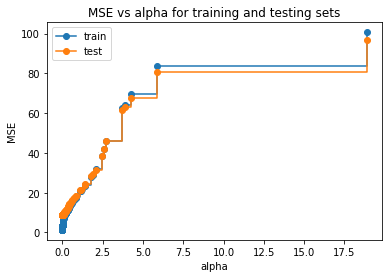

In [282]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("MSE vs alpha for training and testing sets")
ax.plot(ccp_alphas, dtr_mse_train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, dtr_mse_test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()

plt.savefig("dtr_mse.png")
plt.show()

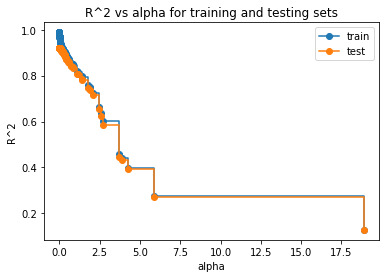

In [283]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("R^2")
ax.set_title("R^2 vs alpha for training and testing sets")
ax.plot(ccp_alphas, dtr_r2_train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, dtr_r2_test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()

plt.savefig("dtr_r2.png")
plt.show()

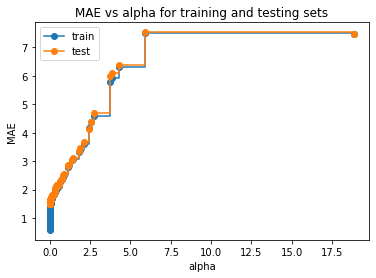

In [281]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("MAE")
ax.set_title("MAE vs alpha for training and testing sets")
ax.plot(ccp_alphas, dtr_mae_train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, dtr_mae_test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()

plt.savefig("dtr_mae.png")
plt.show()

**From these results, we see that the best tree is the first as it has the lowest mean squared error and median absolute error, and the highest R^2 of all of the possibilities. The fact that mse and median absolute error increase and r^2 decreases as higher ccp_alphas are added suggest that the model did not fit properly. A possible explanation is that I did cost compexity pruning on a tree already optimized using GridSearchCV, which was well fitted to the data and became progressively more underfitted as ccp_alpha, and related pruning, increased. Time and computing power make another trial infeasable.**

### Cross validation on best decision tree

In [284]:
#Create a 2D array containing the 5-fold CV results of the best estimator
#Will iterate over train and test set for MSE, R^2, and MAE
scorers = ["neg_mean_squared_error","r2","neg_median_absolute_error"]
X = [X1_train, X1_test]
y= [y1_train, y1_test]
dtr_points = []
t0=time.time()
for i in range(2):
    for j in range(3):
        points = cross_validate(estimator = lots_of_Trees_2.best_estimator_,
                                  scoring=scorers[j], X = X[i], y = y[i], cv = 5)['test_score']
        dtr_points.append(points)
dtr_points = np.abs(np.array(dtr_points))
t1=time.time()
print("Cross validation complete. Total time elapsed: {0:.3f} seconds.".format(t1-t0))

Cross validation complete. Total time elapsed: 0.832 seconds.


In [285]:
#Create Dataframe for standard deviation and mean for all 3 scoring metrics
dtr_std=[]
t0=time.time()
for i in range(6):
    std = np.std(dtr_points[i])
    dtr_std.append(std)
dtr_std_df = pd.DataFrame(np.array(dtr_std).reshape((2,3)), 
                              columns=['MSE','R^2','MAE'], index=['Train','Test'])

dtr_mean=[]
for i in range(6):
    mean = np.mean(dtr_points[i])
    dtr_mean.append(mean)    
dtr_mean_df = pd.DataFrame(np.array(dtr_mean).reshape((2,3)), 
                              columns=['MSE','R^2','MAE'], index=['Train','Test'])

In [286]:
dtr_mean_df

,MSE,R^2,MAE
Train,15.363434,0.866963,1.690229
Test,32.881746,0.698136,2.603326


In [287]:
dtr_std_df

,MSE,R^2,MAE
Train,2.346519,0.019150,0.049907
Test,15.591133,0.154655,0.436453


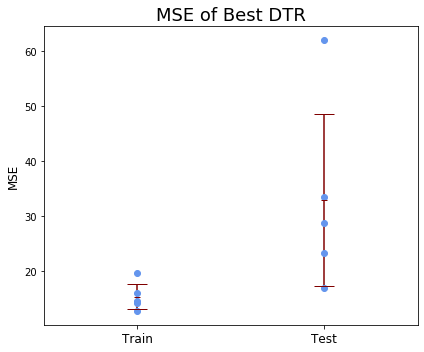

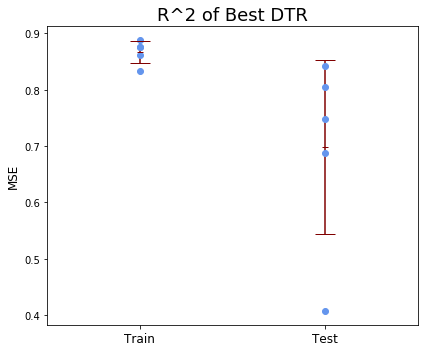

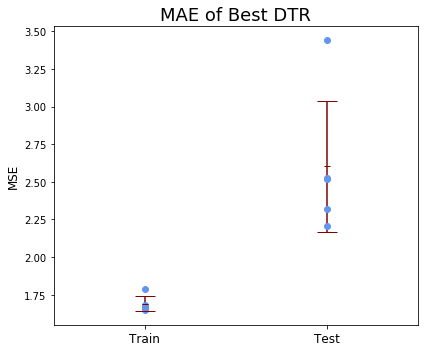

In [299]:
scorenames=['MSE','R^2','MAE']
mean_arr = np.array(dtr_mean).reshape((2,3)) 
std_arr = np.array(dtr_std).reshape((2,3))
dtr_points_arr = dtr_points.reshape((2,3,5))
for i in range(3):
    fig, ax = plt.subplots(figsize=(6,5), tight_layout=True)
    ax.plot([1,1,1,1,1],dtr_points_arr[0][i], linestyle='none',marker="o", color="cornflowerblue",label='train')
    ax.plot([2,2,2,2,2],dtr_points_arr[1][i], linestyle='none',marker="o", color="cornflowerblue",label='test')
    ax.errorbar([1],mean_arr[0][i],std_arr[0][i],
               linestyle='none', marker='_', color='maroon', capsize=10, label='train')
    ax.errorbar([2],mean_arr[1][i],std_arr[1][i],
               linestyle='none', marker='_', color='maroon', capsize=10, label='train')
    ax.set_title("{} of Best DTR".format(scorenames[i]), fontsize=18)
    ax.set_xticklabels(['Train','Test'], fontsize=12)
    ax.set_xticks([1,2])
    ax.set_ylabel("MSE", fontsize=12)
    ax.set_xlim(left=0.5,right=2.5)
    filename="dtr_"+str(scorers[i])+".png"
    plt.savefig(filename)

**The graphs above are indicative of an overfitted model. The metrics for the train set are consistently better than for the test set, and the variance of cross validation scores for the test set is higher than the variance scores for the train set. Another explanation is that the estimator used for cross validation did not inculde a ccp_alpha, which resulted in no pruning in a tree that has split to too great a depth.**

## 2b) Redo of Decision Tree Regressor With Scaled Features

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
#Construct first tree to determine max depth without restrictions
t0=time.time()
reg=DecisionTreeRegressor(random_state=24)
reg.fit(X1sc_train,y1sc_train)
t1=time.time()
print("Time to fit one tree: {0:.3f} seconds.".format(t1-t0))

from sklearn import tree
dot_data = tree.export_graphviz(reg, out_file=None,
                                feature_names=list(all_features),
                                filled=True, 
                                rounded=True,special_characters=True)
import graphviz
graph = graphviz.Source(dot_data).view(filename='scaled_tree.gv')
from graphviz import render
render('dot', 'png', 'scaled_tree.gv')

Time to fit one tree: 0.079 seconds.


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.149045 to fit


'scaled_tree.gv.png'

![scaled tree](scaled_tree.gv.png)

In [20]:
DTR_params_1={
'max_depth' : [7,10,11,12,13,15,20,None],
'min_samples_split': [100,150,175,200,225,250],
'min_samples_leaf': [8,10,11,12,13,14,16],
'max_features': [4,6,8,10,12,15,None]
}

#Print number of parameters entered
param_num = []
for key,value in DTR_params_1.items():
    param_num.append(len(value))
result = 1
for x in param_num: 
    result = result * x  
print("{} hyperparameters will be tested.".format(result)) 

mod=DecisionTreeRegressor(random_state=24)
lots_of_Trees = GridSearchCV(mod, DTR_params_1, cv=5, scoring = 'neg_mean_squared_error', n_jobs=-1)

2352 hyperparameters will be tested.


In [21]:
t0=time.time()
lots_of_Trees.fit(X1sc_train,y1sc_train)
t1=time.time()
print("Fitting Complete. Time elapsed: {0:.3f} seconds.".format(t1-t0))

Fitting Complete. Time elapsed: 64.265 seconds.


In [22]:
print("Parameters of best tree: {}".format(lots_of_Trees.best_params_))
print("Mean Squared Error of best tree: {0:.9f}".format(-1*lots_of_Trees.best_score_))

Parameters of best tree: {'max_depth': 13, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 100}
Mean Squared Error of best tree: 0.161577278


The parameters returned are the same as from the trial without scaled features, but the mean squared error appears to be much lower. PCA-SVR still outperforms DTR, but the difference between is lower than before.

### References

Little MA, McSharry PE, Hunter EJ, Ramig LO (2009),
'Suitability of dysphonia measurements for telemonitoring of Parkinson's 
disease',
IEEE Transactions on Biomedical Engineering, 56(4):1015-1022

Little MA, McSharry PE, Roberts SJ, Costello DAE, Moroz IM.
'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice 
Disorder Detection',
BioMedical Engineering OnLine 2007, 6:23 (26 June 2007) 